In [17]:
#!pip install umap-learn
!pip install umap-learn

In [22]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import pickle
import numpy as np
import umap
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [23]:
!pip show umap

In [24]:
filename = 'glove_6B/glove2word2vec_model.sav'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# Extract word vectors from the model
word_vectors = model

In [25]:
words_of_interest = ["beach", "ocean", "sun", "sand", "waves"]

# Remove missing words and duplicates from the list
unique_words_of_interest = list(set(words_of_interest).intersection(model.key_to_index))

# Retrieve the word vectors for the selected words
vectors_of_interest = [model[word] for word in words_of_interest if word in model.key_to_index]

if not vectors_of_interest:
    print("No valid word vectors found. Please check your input data.")
else:
    reducer = umap.UMAP(n_neighbors=100)
    umap_embeddings = reducer.fit_transform(vectors_of_interest)

/Users/AprilCoffee/opt/anaconda3/envs/tf_cpu/lib/python3.7/site-packages/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [26]:

def drawPlt(umap_embeddings, words_of_interest, highlight_words=None):
    # Create a scatter plot of the UMAP embeddings
    plt.figure(figsize=(10, 8))
    
    # Initialize colors for all points as blue
    point_colors = ['blue'] * len(words_of_interest)
    
    # Change the color for highlighted words to red
    if highlight_words:
        for i, word in enumerate(words_of_interest):
            if word in highlight_words:
                point_colors[i] = 'red'
    
    # Scatter plot all words with smaller circles and updated colors
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], marker='.', s=20, c=point_colors, alpha=0.5)
    
    # Annotate points with words
    for i, word in enumerate(words_of_interest):
        if i < umap_embeddings.shape[0]:  # Check if the index is within bounds
            plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=10)
    
    plt.title("UMAP Visualization of GloVe Word Embeddings")
    plt.xlabel("")
    plt.ylabel("")
    plt.show()


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Choose a target word
target_word = "ocean"
words_of_interest = []
words_of_interest.append(target_word)
# Ensure the target word is in the vocabulary
if target_word in model.key_to_index:
    # Get the vector for the target word
    target_vector = model[target_word].reshape(1, -1)

    # Calculate cosine similarities between the target word and all other words
    similarities = cosine_similarity(target_vector, model.vectors)

    # Find the top N similar words (excluding the target word itself)
    top_n = 200  # Adjust as needed
    similar_word_indices = similarities.argsort()[0][-top_n - 1:-1][::-1]

    # Get the similar words and their similarity scores
    similar_words = [model.index_to_key[i] for i in similar_word_indices]
    similarity_scores = [similarities[0][i] for i in similar_word_indices]
    words_of_interest.extend(similar_words)

    # Print the similar words and their similarity scores
    #for word, score in zip(similar_words, similarity_scores):
    #    print(f"{word}: {score:.4f}")
#else:
#    print(f"{target_word} is not in the vocabulary.")


In [28]:
vectors_of_interest = [model[word] for word in words_of_interest if word in model.key_to_index]

if not vectors_of_interest:
    print("No valid word vectors found. Please check your input data.")
else:
    reducer = umap.UMAP(n_neighbors=10000)
    umap_embeddings = reducer.fit_transform(vectors_of_interest)

/Users/AprilCoffee/opt/anaconda3/envs/tf_cpu/lib/python3.7/site-packages/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [29]:
#drawPlt(umap_embeddings,words_of_interest,target_word)

In [30]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# Assuming you have loaded GloVe embeddings and vectors_of_interest
# vectors_of_interest is a list of word vectors

# Number of clusters (you can adjust this)
num_clusters = 20

# Normalize the word vectors (important for K-Means)
normalized_vectors = normalize(vectors_of_interest)

# Initialize and fit K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(normalized_vectors)

# Get the cluster labels for each word vector
cluster_labels = kmeans.labels_

# Print the words and their respective clusters
#for word, cluster in zip(words_of_interest, cluster_labels):
#    print(f"{word}: Cluster {cluster}")

# Analyze and visualize the clusters as needed


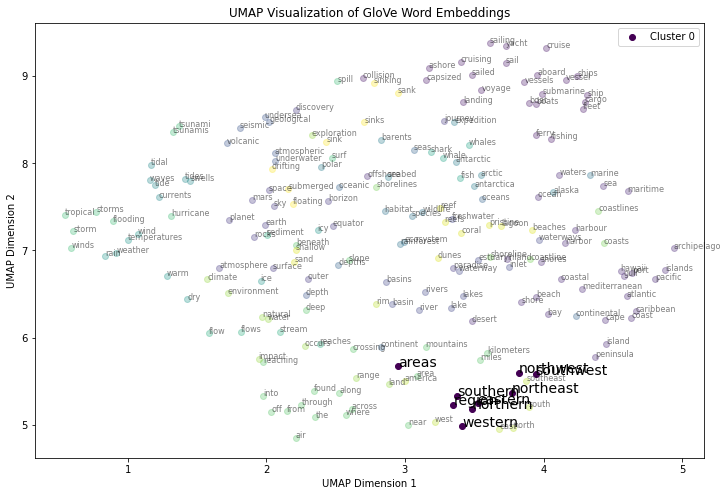

Cluster 0 Labels: northeast, southern, southwest, northwest, western, northern, areas, region, eastern
Cluster 1 Labels: boat, ship, vessel, fishing, boats, sail, sailing, ships, voyage, ashore, vessels, submarine, cruising, aboard, cruise, fleet, landing, sailed, collision, cargo, ferry, capsized, yacht
Cluster 2 Labels: ocean, sea, waters, coast, atlantic, pacific, coastal, shores, shore, mediterranean, islands, island, inland, caribbean, harbor, gulf, cape, beach, archipelago, offshore, maritime, desert, harbour, peninsula, bay, hawaii, port
Cluster 3 Labels: earth, surface, horizon, planet, discovery, mars, sky, space, outer, paradise, atmosphere, rocks, equator, journey
Cluster 4 Labels: basin, lakes, lake, river, rivers, waterways, estuary, inlet, basins, freshwater, waterway
Cluster 5 Labels: underwater, undersea, atmospheric, seismic, geological, depth, volcanic
Cluster 6 Labels: seas, oceans, depths, oceanic, continental, continent
Cluster 7 Labels: marine, rainforest, ecosyst

In [31]:
import matplotlib.pyplot as plt
import umap
import numpy as np

def drawPlt(umap_embeddings, words_of_interest, target_word, cluster_labels, focus_cluster=None, opacity=0.5, label_opacity=1.0, label_size=12):
    # Create a scatter plot of UMAP embeddings
    plt.figure(figsize=(12, 8))

    # Define unique colors for each cluster
    unique_clusters = set(cluster_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

    # Lists to store cluster labels
    cluster_label_lists = [[] for _ in range(len(unique_clusters))]

    # Plot points in focus cluster with full opacity
    for cluster in unique_clusters:
        mask = cluster_labels == cluster
        if cluster == focus_cluster:
            plt.scatter(
                umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=f"Cluster {cluster}", color=colors[cluster], alpha=1.0
            )
            label_alpha = 1.0  # Full opacity for labels of the focus cluster
            label_size_cluster = label_size  # Adjust label size for the focus cluster
        else:
            plt.scatter(
                umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                color=colors[cluster], alpha=opacity
            )
            label_alpha = label_opacity  # Adjusted opacity for labels of other clusters
            label_size_cluster = 8  # Smaller label size for other clusters

        # Annotate points with words and set label opacity and size
        for i, word in enumerate(words_of_interest):
            if cluster_labels[i] == cluster:
                plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), alpha=label_alpha, fontsize=label_size_cluster)
                cluster_label_lists[cluster].append(word)

    plt.title("UMAP Visualization of GloVe Word Embeddings")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend()

    # Save the plot as an image file
    plt.savefig("cluster_visualization.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    # Return the cluster label lists
    return cluster_label_lists

# Assuming you have 'umap_embeddings', 'words_of_interest', 'target_word', 'cluster_labels', and 'focus_cluster'
# 'cluster_labels' should contain the cluster labels for each word in 'words_of_interest'
# 'focus_cluster' should be the cluster number you want to highlight with full opacity

# Call drawPlt with UMAP embeddings, words_of_interest, cluster_labels, and focus_cluster
cluster_label_lists = drawPlt(umap_embeddings, words_of_interest, target_word, cluster_labels, focus_cluster=0, opacity=0.3, label_opacity=0.5, label_size=14)

# cluster_label_lists will contain lists of labels for each cluster
for cluster, labels in enumerate(cluster_label_lists):
    print(f"Cluster {cluster} Labels: {', '.join(labels)}")


In [32]:
cluster_label_lists[0]

['northeast',
 'southern',
 'southwest',
 'northwest',
 'western',
 'northern',
 'areas',
 'region',
 'eastern']

In [52]:

import openai
import api_key

openai.api_key = api_key.openai_key()

input_text = ','.join(cluster_label_lists[1])


response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature = 1.2,
        messages=[
            {"role": "system", "content": 
            '''
            Stable Diffusion is an AI art generation model similar to DALLE.
            Below is a list of prompts that can be used to generate images with Stable Diffusion:

            - portait of a homer simpson archer shooting arrow at forest monster, front game card, drark, marvel comics, dark, intricate, highly detailed, smooth, artstation, digital illustration by ruan jia and mandy jurgens and artgerm and wayne barlowe and greg rutkowski and zdislav beksinski
            - pirate, concept art, deep focus, fantasy, intricate, highly detailed, digital painting, artstation, matte, sharp focus, illustration, art by magali villeneuve, chippy, ryan yee, rk post, clint cearley, daniel ljunggren, zoltan boros, gabor szikszai, howard lyon, steve argyle, winona nelson
            - ghost inside a hunted room, art by lois van baarle and loish and ross tran and rossdraws and sam yang and samdoesarts and artgerm, digital art, highly detailed, intricate, sharp focus, Trending on Artstation HQ, deviantart, unreal engine 5, 4K UHD image
            - red dead redemption 2, cinematic view, epic sky, detailed, concept art, low angle, high detail, warm lighting, volumetric, godrays, vivid, beautiful, trending on artstation, by jordan grimmer, huge scene, grass, art greg rutkowski
            - a fantasy style portrait painting of rachel lane / alison brie hybrid in the style of francois boucher oil painting unreal 5 daz. rpg portrait, extremely detailed artgerm greg rutkowski alphonse mucha greg hildebrandt tim hildebrandt
            - athena, greek goddess, claudia black, art by artgerm and greg rutkowski and magali villeneuve, bronze greek armor, owl crown, d & d, fantasy, intricate, portrait, highly detailed, headshot, digital painting, trending on artstation, concept art, sharp focus, illustration
            - closeup portrait shot of a large strong female biomechanic woman in a scenic scifi environment, intricate, elegant, highly detailed, centered, digital painting, artstation, concept art, smooth, sharp focus, warframe, illustration, thomas kinkade, tomasz alen kopera, peter mohrbacher, donato giancola, leyendecker, boris vallejo
            - ultra realistic illustration of steve urkle as the hulk, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha
            – portrait of beautiful happy young ana de armas, ethereal, realistic anime, trending on pixiv, detailed, clean lines, sharp lines, crisp lines, award winning illustration, masterpiece, 4k, eugene de blaas and ross tran, vibrant color scheme, intricately detailed
            – alberto seveso and geo2099 style, A highly detailed and hyper realistic portrait of a gorgeous young ana de armas, lisa frank, trending on artstation, butterflies, floral, sharp focus, studio photo, intricate details, highly detailed, by Tvera and wlop and artgerm


            I want you to write me a detailed prompt exactly about the idea written after IDEA. 
            Following the structure of the example prompts. 
            This means a very SHORT description of the scene, followed by modifiers divided by commas to alter the mood, style, lighting, and more.
           '''
            },

            #{"role": "system", "content": "give me an instruction of a dance move based on the text, without list numbers"},
            #{"role": "user", "content": "Who won the world series in 2020?"},
            #{"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
            {"role": "user", "content": 
         '''IDEA: A photorealistic, highly detailed ''' + input_text}
        ]
)
print(response['choices'][0]['message']['content'])
output = response['choices'][0]['message']['content']
#os.system("say -v anna '"+output+"'") 
#os.system("say '"+output+"'") 


A detailed, photorealistic scene showcasing a majestic ship sailing through calm waters under a dramatic sunset sky. The ship is adorned with intricate details, depicting its history and character. The warm hues of the sunset light illuminate the vessel, casting intricate shadows on the surface of the water. The ship is surrounded by a fleet of fishing boats, enriching the scene with a sense of community and maritime activity. In the distance, a dazzling yacht emerges, showcasing elegant lines and state-of-the-art engineering. As the sun sets, the serene voyage takes a dramatic turn when a submarine gracefully emerges from the depths, symbolizing the hidden mysteries of the ocean. Despite the unexpected encounter, the ship confidently navigates the waters, its skilled crew remaining composed even amidst a challenging situation.


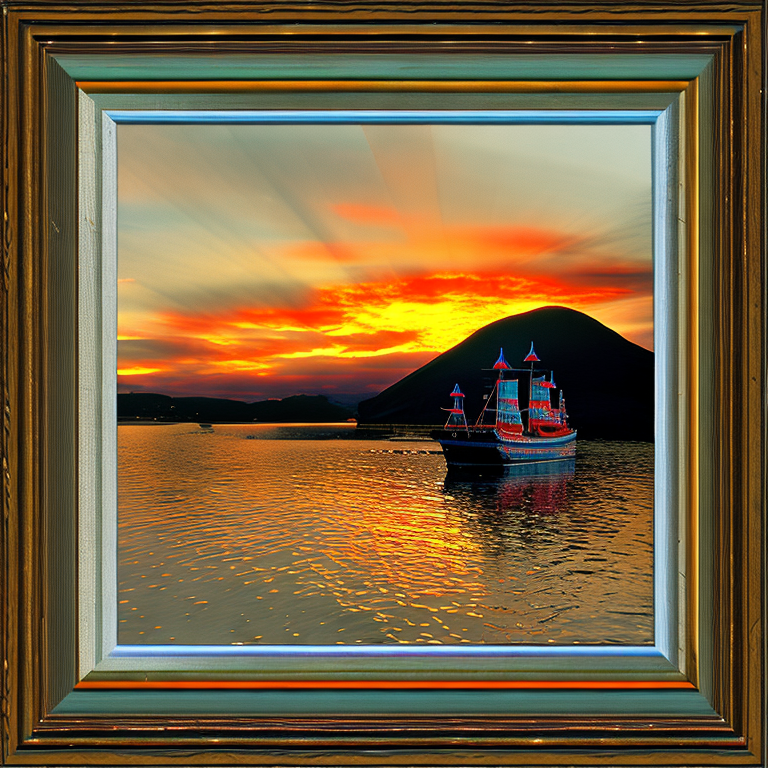

In [54]:
# Setting up enviornment
from base64 import b64decode
from pathlib import Path
import os
import io
import warnings
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'
os.environ['STABILITY_KEY'] = api_key.dreamStudio_key()

# Set up our connection to the API.
# select the engine using. (possible for stable diffusion 2)

stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-768-v2-1", # Set the engine to use for generation. 
)

# Set up our initial generation parameters.
answers = stability_api.generate(
    prompt=output,
    width=768, # Generation width, defaults to 512 if not included.
    height=768, # Generation height, defaults to 512 if not included.
)

IMAGE_DIR = Path.cwd() / "StableDiffusion_images"
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

fileName = "image.png"
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.type == generation.ARTIFACT_IMAGE:
            image_file = IMAGE_DIR / fileName
            img = Image.open(io.BytesIO(artifact.binary))
            img.save(image_file) # Save our generated images with their seed number as the filename.
            
display(img)